In [1]:
import os, sys
from tabnanny import verbose
os.chdir('/Users/dananjayaliyanage/jail/Bayesian_parameter_inferece_for_VAH/emulation_and_calibration')
sys.path.append('/Users/dananjayaliyanage/jail/Bayesian_parameter_inferece_for_VAH/surmise')
import dill as pickle
import numpy as np
import time
from split_data import generate_split_data
from surmise.emulation import emulator
from plotting import *
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                  reload_support=True)

(None, <pyximport.pyximport.PyxImporter at 0x7ff52e0e5ad0>)

In [2]:
seconds_st = time.time()

# Note: Here we can create different funcs to split data into training and test
drop_obs_group = ['fluct']
drop_subset = [f'{oob}_{cen}' for og in drop_obs_group for oob in obs_groups[og] for cen in obs_cent_list['Pb-Pb-2760'][oob]]
print(f'We drop these observables {drop_subset}')
f_train, f_test, theta_train, theta_test, sd_train, sd_test, y, thetanames = generate_split_data(drop_list=drop_subset)
print(f'Number of model inputs {theta_train.shape[1]}')

x_np = np.arange(0, f_train.shape[1])[:, None]
x_np = x_np.astype('object')

We drop these observables ['pT_fluct_[0 5]', 'pT_fluct_[ 5 10]', 'pT_fluct_[10 15]', 'pT_fluct_[15 20]', 'pT_fluct_[20 25]', 'pT_fluct_[25 30]', 'pT_fluct_[30 35]', 'pT_fluct_[35 40]', 'pT_fluct_[40 45]', 'pT_fluct_[45 50]', 'pT_fluct_[50 55]', 'pT_fluct_[55 60]']
Designs that have more that 5 failure event rate 
 [ 13.  14.  19.  23.  27.  31.  32.  43.  59.  71.  75.  91.  92.  93.
  98. 123. 127. 129. 131. 142. 143. 146. 156. 160. 162. 168. 169. 170.
 171. 174. 184. 186. 187. 190. 194. 195. 196. 198. 210. 217. 233. 236.
 239. 243. 245. 248. 249. 260. 262. 266. 269. 277. 282. 283. 286. 291.
 293. 299.]
Designs that have more that 5 failure event rate 
 [ 4.  6. 10. 27. 29. 35. 38. 39. 43. 44. 63. 65. 70. 73. 76. 84. 85. 87.
 88.]
Designs that have more that 5 failure event rate 
 [10. 17. 18. 22. 27. 35. 41. 49. 58. 82. 88.]
Designs that have more that 5 failure event rate 
 [ 0.  3.  6. 16. 18. 20. 22. 26. 33. 35. 37. 41. 42. 48. 52. 68. 71. 82.
 83. 88.]
Designs that have more that

In [3]:
fcal = f_train
thetacal = theta_train
sdcal = sd_train

In [4]:
print(f'Shape of the emulation data set {thetacal.shape}')
x_np = np.arange(0, fcal.shape[1])[:, None]
x_np = x_np.astype('object')

##########################################################
# Note: Pick method_name = 'PCGPwM' or 'PCGPR' or 'PCSK'
##########################################################

method_name = 'PCSK'
is_train = True
emu_path = 'VAH_validate_' + method_name + '.pkl' 
        
prior_min = [10, -0.7, 0.5, 0, 0.3, 0.135, 0.13, 0.01, -2, -1, 0.01, 0.12, 0.025, -0.8, 0.3]
prior_max = [30, 0.7, 1.5, 1.7, 2, 0.165, 0.3, 0.2, 1, 2, 0.25, 0.3, 0.15, 0.8, 1]
prior_dict = {'min': prior_min, 'max': prior_max}

if (os.path.exists(emu_path)) and (is_train==False):
    print('Saved emulators exists and overide is prohibited')
    with open(emu_path, 'rb') as file:
        emu_tr = pickle.load(file)    
else:
    print('training emulators')
    if method_name == 'PCGPwM':
        emu_tr = emulator(x=x_np,
                          theta=thetacal,
                          f=fcal.T,
                          method='PCGPwM',
                          args={'epsilon': 0.05})
        
    elif method_name == 'PCGPR':
        emu_tr = emulator(x=x_np,
                          theta=thetacal,
                          f=fcal.T,
                          method='PCGPR',
                          args={'epsilon': 0.02,
                                'prior': prior_dict})
    elif method_name == 'PCSK':
        #Scale pt_fluc uncertainity
        #l_in=index['pT_fluct']
        #print(l_in)
        #sdcal[:,index['pT_fluct'][0]:-1] =  10* sdcal[:,index['pT_fluct'][0]:-1]
        #sdcal = np.sqrt(np.absolute(sdcal))
        emu_tr = emulator(x=x_np,
                          theta=thetacal,
                          f=fcal.T,
                          method='PCSK',
                          args={'numpcs': 12, # this does not mean full errors
                                'simsd': np.absolute(sdcal.T),
                                'verbose': 1})


    if (is_train==True) or not(os.path.exists(emu_path)):
        with open(emu_path, 'wb') as file:
            pickle.dump(emu_tr, file)


seconds_end = time.time()
print('Total emu time:', seconds_end - seconds_st)


seconds_st = time.time()

Shape of the emulation data set (471, 15)
training emulators
PCSK considering  12 PCs

 interation number 0 : 0% 17.0 % 25.0 % 33.0 % 42.0 % 58.0 % 67.0 % 75.0 % 83.0 % 92.0 % 
 interation number 1 : 0% 17.0 % 25.0 % 33.0 % 42.0 % 58.0 % 67.0 % 75.0 % 83.0 % 92.0 % Total emu time: 69.76449203491211


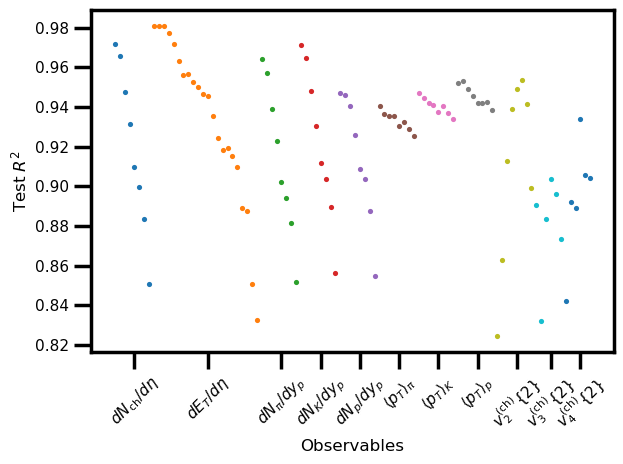

Total emu time: 1468.0930397510529


In [38]:
pred_test = emu_tr.predict(x=x_np, theta=theta_test)
pred_test_mean = pred_test.mean()
pred_test_var = pred_test.var()
pred_test_sigma = np.sqrt(pred_test_var)
# Plotting diagnostics
#plot_UQ(f_test, pred_test_mean.T, np.sqrt(pred_test_var.T), method=method_name, drop=drop_obs_group)
plot_R2(pred_test_mean, f_test.T, method=method_name, drop=drop_obs_group)

seconds_end = time.time()
print('Total emu time:', seconds_end - seconds_st)


seconds_st = time.time()

In [25]:
index={}
st_index=0
for obs_group in  obs_groups.keys():
    if obs_group in drop_obs_group:
        continue;
    for obs in obs_groups[obs_group]:
        n_centrality = len(obs_cent_list['Pb-Pb-2760'][obs])
        index[obs]=[st_index,st_index+n_centrality]
        st_index = st_index + n_centrality

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
pred_test_var

array([[2.44718066e+03, 2.57102953e+03, 2.85773912e+03, ...,
        2.19613057e+03, 1.64356999e+03, 9.82107885e+02],
       [1.51786357e+03, 1.63595453e+03, 1.81476289e+03, ...,
        1.42245096e+03, 1.02586720e+03, 5.97773446e+02],
       [8.80197436e+02, 9.77579566e+02, 1.07556049e+03, ...,
        8.55325169e+02, 5.99303437e+02, 3.51977637e+02],
       ...,
       [1.79095546e-06, 2.31420987e-06, 2.46312715e-06, ...,
        1.74145794e-06, 1.48719934e-06, 1.50581293e-06],
       [2.05766770e-06, 2.64868458e-06, 2.81228578e-06, ...,
        1.98148666e-06, 1.67884063e-06, 1.67626035e-06],
       [2.47260287e-06, 3.15327899e-06, 3.34491020e-06, ...,
        2.35317755e-06, 1.98725079e-06, 1.95772152e-06]])

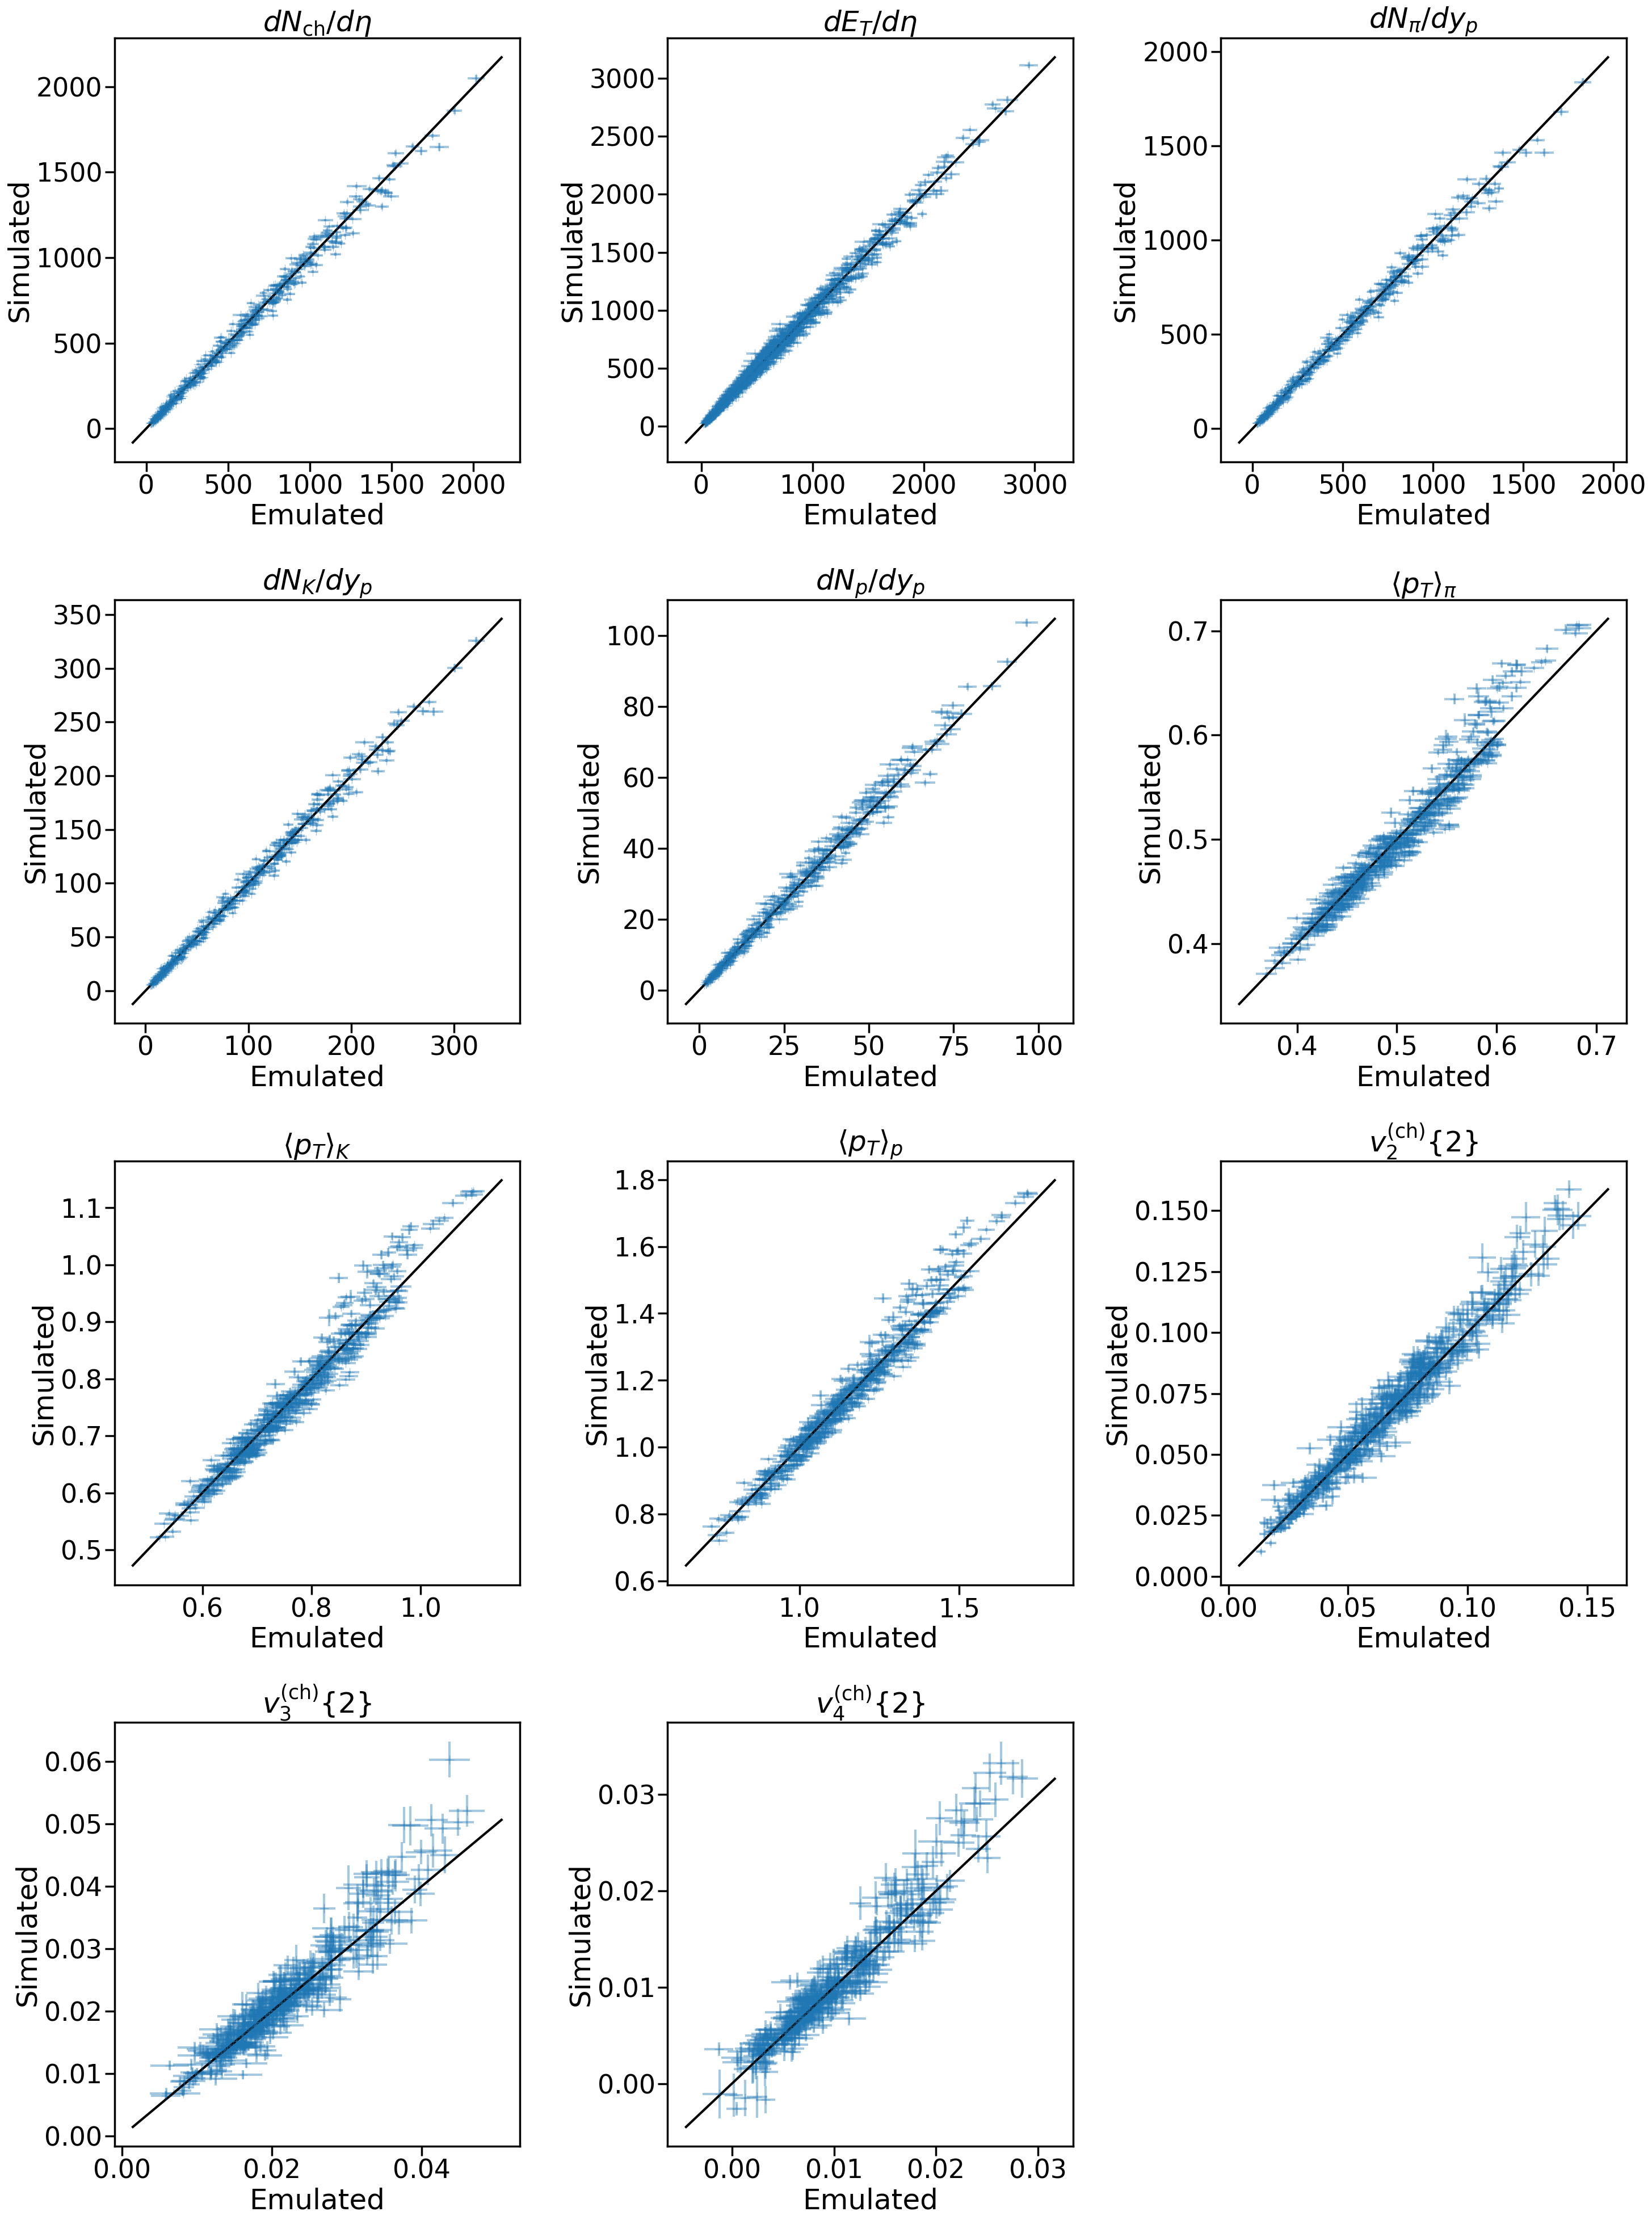

In [53]:
sns.set_context('poster', font_scale=1.5)
fig, axs = plt.subplots(4,3,figsize=(30,40))
axs = axs.flatten()
keep_ylabel = [0, 3, 6, 9]
keep_ylabel = []
for i, k in enumerate(index.keys()):
    #print(k)
    low = index[k][0]
    high = index[k][1]
    ax = axs[i]
    emu_mean  = pred_test_mean[low:high,:].flatten()
    emu_err  = pred_test_sigma[low:high,:].flatten()
    sim_mean = f_test.T[low:high,:].flatten()
    sim_err = sd_test.T[low:high,:].flatten()
    ax.errorbar(emu_mean, sim_mean, fmt='+', xerr=emu_err, yerr=sim_err, alpha = 0.4 )
    ax.set_title(obs_tex_labels[k])
    ax.plot(ax.get_xlim(), ax.get_xlim(), color='k')
    ax.set_xlabel('Emulated')
    ax.set_ylabel('Simulated')
fig.delaxes(axs[-1])
plt.tight_layout()
plt.savefig('emulated_vs_simulated.png', dpi=100)
    #print(y.columns[low:high])

In [21]:
pred_test_mean.shape

(98, 70)